In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
import pandas as pd

# Load the datasets
train_path = 'train.csv'
test_path = 'test.csv'

# Read the datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display basic information about the datasets
train_info = train_data.info()
test_info = test_data.info()

# Display the first few rows of each dataset
train_head = train_data.head()
test_head = test_data.head()

train_info, test_info, train_head, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

(None,
 None,
    Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
 0           0   70172    Male     Loyal Customer   13  Personal Travel   
 1           1    5047    Male  disloyal Customer   25  Business travel   
 2           2  110028  Female     Loyal Customer   26  Business travel   
 3           3   24026  Female     Loyal Customer   25  Business travel   
 4           4  119299    Male     Loyal Customer   61  Business travel   
 
       Class  Flight Distance  Inflight wifi service  \
 0  Eco Plus              460                      3   
 1  Business              235                      3   
 2  Business             1142                      2   
 3  Business              562                      2   
 4  Business              214                      3   
 
    Departure/Arrival time convenient  ...  Inflight entertainment  \
 0                                  4  ...                       5   
 1                                  2  ...              

In [ ]:
# Prima analisi: Cerchiamo outlier e dati mancanti

# Percentuale di valori mancanti nel dataset di training
missing_train = train_data.isnull().mean() * 100

# Percentuale di valori mancanti nel dataset di test
missing_test = test_data.isnull().mean() * 100

# Individuazione di potenziali outlier attraverso una statistica descrittiva
train_stats = train_data.describe()

missing_train, missing_test, train_stats


(Unnamed: 0                           0.000000
 id                                   0.000000
 Gender                               0.000000
 Customer Type                        0.000000
 Age                                  0.000000
 Type of Travel                       0.000000
 Class                                0.000000
 Flight Distance                      0.000000
 Inflight wifi service                0.000000
 Departure/Arrival time convenient    0.000000
 Ease of Online booking               0.000000
 Gate location                        0.000000
 Food and drink                       0.000000
 Online boarding                      0.000000
 Seat comfort                         0.000000
 Inflight entertainment               0.000000
 On-board service                     0.000000
 Leg room service                     0.000000
 Baggage handling                     0.000000
 Checkin service                      0.000000
 Inflight service                     0.000000
 Cleanliness 

In [ ]:
# Gestione dei valori mancanti: sostituendo con la mediana per "Arrival Delay in Minutes"
train_data['Arrival Delay in Minutes'].fillna(train_data['Arrival Delay in Minutes'].median(), inplace=True)

# Identificazione degli outlier usando il metodo IQR
Q1 = train_data['Departure Delay in Minutes'].quantile(0.25)
Q3 = train_data['Departure Delay in Minutes'].quantile(0.75)
IQR = Q3 - Q1

# Identificare i valori al di fuori dell'1.5 * IQR come potenziali outlier
outliers = train_data[(train_data['Departure Delay in Minutes'] < (Q1 - 1.5 * IQR)) |
                      (train_data['Departure Delay in Minutes'] > (Q3 + 1.5 * IQR))]

# Percentuale di outlier nel dataset di training
outlier_percentage = (len(outliers) / len(train_data)) * 100

outlier_percentage, train_data['Arrival Delay in Minutes'].isnull().sum()  # Conferma dei valori mancanti gestiti


(13.983099784416384, 0)

In [ ]:
# Analisi delle variabili categoriche nel dataset di training
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Vediamo i valori unici delle colonne categoriche
categorical_values = {col: train_data[col].unique() for col in categorical_columns}

# Procediamo con la standardizzazione delle feature numeriche (escludendo la colonna delle etichette e variabili categoriche)
from sklearn.preprocessing import StandardScaler

# Selezioniamo le feature numeriche da standardizzare (escludendo la colonna di etichetta e ID)
numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.difference(['id', 'Unnamed: 0'])

# Standardizziamo le feature numeriche
scaler = StandardScaler()
train_data_scaled = train_data.copy()
train_data_scaled[numeric_columns] = scaler.fit_transform(train_data_scaled[numeric_columns])

categorical_columns, categorical_values, train_data_scaled.head()


(Index(['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'], dtype='object'),
 {'Gender': array(['Male', 'Female'], dtype=object),
  'Customer Type': array(['Loyal Customer', 'disloyal Customer'], dtype=object),
  'Type of Travel': array(['Personal Travel', 'Business travel'], dtype=object),
  'Class': array(['Eco Plus', 'Business', 'Eco'], dtype=object),
  'satisfaction': array(['neutral or dissatisfied', 'satisfied'], dtype=object)},
    Unnamed: 0      id  Gender      Customer Type       Age   Type of Travel  \
 0           0   70172    Male     Loyal Customer -1.745279  Personal Travel   
 1           1    5047    Male  disloyal Customer -0.951360  Business travel   
 2           2  110028  Female     Loyal Customer -0.885200  Business travel   
 3           3   24026  Female     Loyal Customer -0.951360  Business travel   
 4           4  119299    Male     Loyal Customer  1.430397  Business travel   
 
       Class  Flight Distance  Inflight wifi service  \
 0  

In [ ]:
# One-Hot Encoding delle variabili categoriche nel dataset di training e test
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Visualizzazione delle prime righe del dataset di training codificato
train_data_encoded.head()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0,70172,13,460,3,4,3,1,5,3,...,5,5,25,18.0,True,False,True,False,True,False
1,1,5047,25,235,3,2,3,3,1,3,...,4,1,1,6.0,True,True,False,False,False,False
2,2,110028,26,1142,2,2,2,2,5,5,...,4,5,0,0.0,False,False,False,False,False,True
3,3,24026,25,562,2,5,5,5,2,2,...,4,2,11,9.0,False,False,False,False,False,False
4,4,119299,61,214,3,3,3,3,4,5,...,3,3,0,0.0,True,False,False,False,False,True


In [ ]:
# Calcolare la matrice di correlazione
correlation_matrix = train_data_encoded.corr()

# Identificare le correlazioni elevate (> 0.9) per la multicollinearità
high_correlation = correlation_matrix[correlation_matrix > 0.9]

# Verificare il bilanciamento del dataset in termini di 'satisfaction'
satisfaction_balance = train_data_encoded['satisfaction_satisfied'].value_counts(normalize=True) * 100

print(satisfaction_balance)


satisfaction_satisfied
False    56.666731
True     43.333269
Name: proportion, dtype: float64


In [ ]:
# Contare le occorrenze di ciascuna classe
class_counts = train_data['satisfaction'].value_counts()

# Calcolare le percentuali per ogni classe
class_percentages = train_data['satisfaction'].value_counts(normalize=True) * 100

print(class_counts)
print(class_percentages)


satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64
satisfaction
neutral or dissatisfied    56.666731
satisfied                  43.333269
Name: proportion, dtype: float64


In [ ]:
# Calcolare la matrice di correlazione per le variabili numeriche
correlation_matrix = train_data_encoded.corr()

# Identificare casi di multicollinearità (correlazione uguale a 1)
multicollinearity = correlation_matrix[correlation_matrix == 1.0]

# Stampare la matrice di correlazione e i casi di multicollinearità
print(correlation_matrix)
print(multicollinearity)


                                   Unnamed: 0        id       Age  \
Unnamed: 0                           1.000000  0.002991  0.004786   
id                                   0.002991  1.000000  0.022857   
Age                                  0.004786  0.022857  1.000000   
Flight Distance                      0.002794  0.095544  0.099461   
Inflight wifi service               -0.002490 -0.021276  0.017859   
Departure/Arrival time convenient    0.000739 -0.002110  0.038125   
Ease of Online booking               0.001913  0.014163  0.024842   
Gate location                        0.005073 -0.000606 -0.001330   
Food and drink                      -0.002162  0.001063  0.023000   
Online boarding                      0.001002  0.055477  0.208939   
Seat comfort                         0.000044  0.052903  0.160277   
Inflight entertainment               0.001363  0.002300  0.076444   
On-board service                     0.000813  0.055241  0.057594   
Leg room service                  

In [ ]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Filtra solo le colonne numeriche
X = train_data_encoded.select_dtypes(include=[np.number])

# Verifica se ci sono NaN o inf e sostituiscili o eliminali
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Calcola il VIF per ogni feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)



                              feature        VIF
0                          Unnamed: 0   3.722234
1                                  id   4.018827
2                                 Age   7.388070
3                     Flight Distance   2.664430
4               Inflight wifi service  12.537346
5   Departure/Arrival time convenient   7.205948
6              Ease of Online booking  12.952496
7                       Gate location   8.875843
8                      Food and drink  13.791843
9                     Online boarding  12.754962
10                       Seat comfort  18.423337
11             Inflight entertainment  26.530753
12                   On-board service  13.809500
13                   Leg room service   9.502677
14                   Baggage handling  19.146991
15                    Checkin service   9.332485
16                   Inflight service  20.845972
17                        Cleanliness  20.392819
18         Departure Delay in Minutes  14.810031
19           Arrival

In [ ]:
# Filtra le variabili con VIF minore di 10
low_vif_features = vif_data[vif_data['VIF'] <= 10]['feature'].tolist()

# Aggiorniamo il dataset rimuovendo le colonne con VIF elevato
X_filtered = X[low_vif_features]

# Stampiamo il dataset filtrato
print(f"Feature selezionate (VIF <= 10):\n{X_filtered.columns}")
print(X_filtered)



Feature selezionate (VIF <= 10):
Index(['Unnamed: 0', 'id', 'Age', 'Flight Distance',
       'Departure/Arrival time convenient', 'Gate location',
       'Leg room service', 'Checkin service'],
      dtype='object')
        Unnamed: 0      id  Age  Flight Distance  \
0                0   70172   13              460   
1                1    5047   25              235   
2                2  110028   26             1142   
3                3   24026   25              562   
4                4  119299   61              214   
...            ...     ...  ...              ...   
103899      103899   94171   23              192   
103900      103900   73097   49             2347   
103901      103901   68825   30             1995   
103902      103902   54173   22             1000   
103903      103903   62567   27             1723   

        Departure/Arrival time convenient  Gate location  Leg room service  \
0                                       4              1                 3   
1  

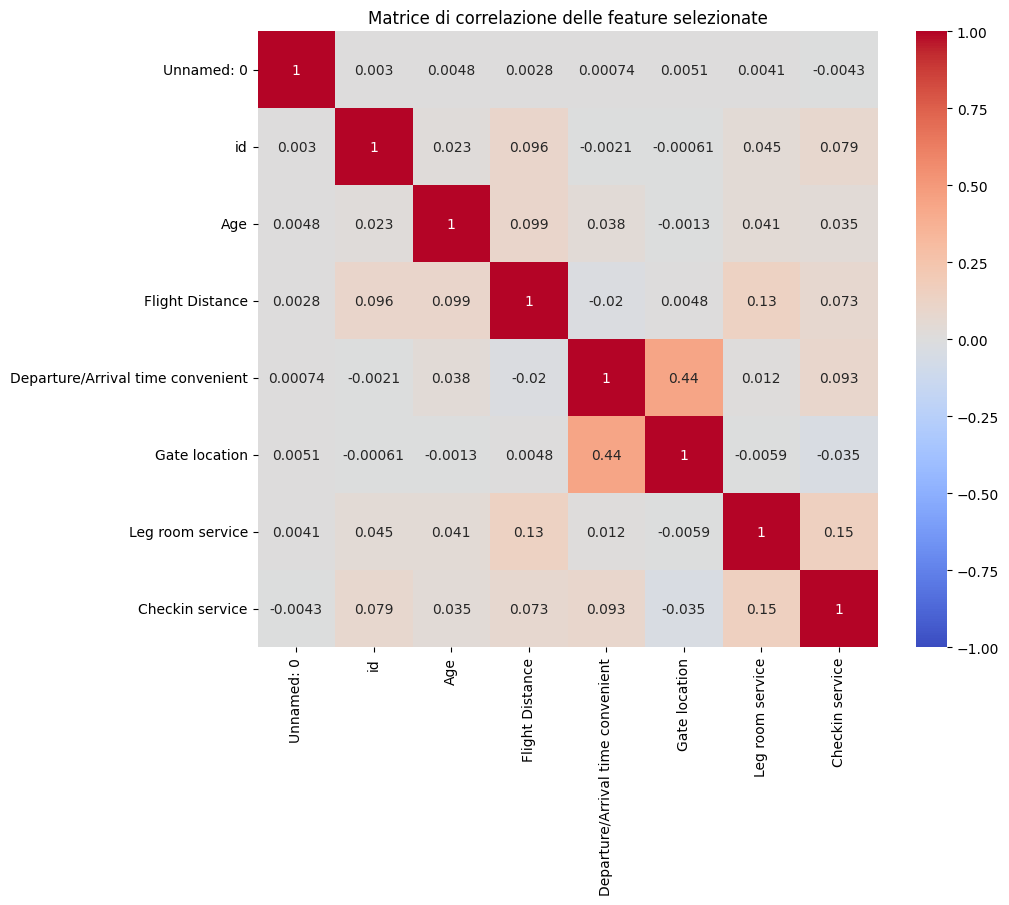

In [ ]:
# Calcoliamo la matrice di correlazione per le feature selezionate
correlation_matrix_filtered = X_filtered.corr()

# Visualizziamo la matrice di correlazione
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di correlazione delle feature selezionate')
plt.show()


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2

# Discretizziamo le variabili numeriche usando KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_chi2_discretized = kbins.fit_transform(X_filtered)

# Eseguiamo il test del Chi-square
y = train_data_encoded['satisfaction_satisfied']  # Variabile target

chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_chi2_discretized, y)

# Visualizziamo i punteggi del test Chi-square
chi2_scores = pd.DataFrame({"Feature": X_filtered.columns, "Chi2 Score": chi2_selector.scores_})
chi2_scores = chi2_scores.sort_values(by='Chi2 Score', ascending=False)
print(chi2_scores)



                             Feature    Chi2 Score
3                    Flight Distance  12325.032758
6                   Leg room service   3528.602629
7                    Checkin service   1742.027789
2                                Age   1350.753334
4  Departure/Arrival time convenient    206.550984
5                      Gate location     48.975149
1                                 id     22.589507
0                         Unnamed: 0      2.373267


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Calcoliamo la Mutual Information
mi_scores = mutual_info_classif(X_filtered, y)

# Visualizziamo i risultati
mi_scores_df = pd.DataFrame({"Feature": X_filtered.columns, "MI Score": mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

print(mi_scores_df)


                             Feature  MI Score
1                                 id  0.154429
3                    Flight Distance  0.063219
6                   Leg room service  0.061432
2                                Age  0.044937
7                    Checkin service  0.033112
5                      Gate location  0.016596
4  Departure/Arrival time convenient  0.005435
0                         Unnamed: 0  0.000000


In [ ]:
from scipy.stats import ttest_ind

# Eseguiamo il T-test per ogni feature continua
t_test_results = {}
for feature in X_filtered.columns:
    group1 = X_filtered[train_data_encoded['satisfaction_satisfied'] == 1][feature]
    group2 = X_filtered[train_data_encoded['satisfaction_satisfied'] == 0][feature]

    # Calcoliamo il T-test tra i due gruppi
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)  # Impostiamo equal_var=False se non si assume varianza uguale
    t_test_results[feature] = p_val

# Creiamo un DataFrame per visualizzare i risultati del T-test
t_test_df = pd.DataFrame(list(t_test_results.items()), columns=['Feature', 'P-value']).sort_values(by='P-value')
print(t_test_df)


                             Feature       P-value
2                                Age  0.000000e+00
3                    Flight Distance  0.000000e+00
6                   Leg room service  0.000000e+00
7                    Checkin service  0.000000e+00
4  Departure/Arrival time convenient  1.190888e-61
1                                 id  9.404291e-06
0                         Unnamed: 0  1.273660e-01
5                      Gate location  8.290717e-01


In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Definire i modelli da testare
models = {
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# Esegui uno spot check con k-fold cross validation
for name, model in models.items():
    scores = cross_val_score(model, X_filtered, y, cv=5, scoring='accuracy')
    print(f'{name} Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')




RandomForest Accuracy: 0.7389 ± 0.0925
AdaBoost Accuracy: 0.6455 ± 0.1260
LogisticRegression Accuracy: 0.6252 ± 0.0331


In [ ]:
# Definiamo la griglia di parametri per RandomForest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# Grid Search per RandomForest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_filtered, y)

print(f"Best RandomForest Params: {grid_search_rf.best_params_}")
print(f"Best RandomForest Accuracy: {grid_search_rf.best_score_:.4f}")

# Definiamo la griglia di parametri per AdaBoost
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Grid Search per AdaBoost
grid_search_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid_adaboost, cv=5, scoring='accuracy')
grid_search_adaboost.fit(X_filtered, y)

print(f"Best AdaBoost Params: {grid_search_adaboost.best_params_}")
print(f"Best AdaBoost Accuracy: {grid_search_adaboost.best_score_:.4f}")


Best RandomForest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RandomForest Accuracy: 0.7383
Best AdaBoost Params: {'learning_rate': 0.1, 'n_estimators': 50}
Best AdaBoost Accuracy: 0.7461


In [ ]:
# Valutiamo i migliori modelli con la cross-validation
best_rf = grid_search_rf.best_estimator_
best_adaboost = grid_search_adaboost.best_estimator_

rf_scores = cross_val_score(best_rf, X_filtered, y, cv=5, scoring='accuracy')
adaboost_scores = cross_val_score(best_adaboost, X_filtered, y, cv=5, scoring='accuracy')

print(f"RandomForest CV Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"AdaBoost CV Accuracy: {adaboost_scores.mean():.4f} ± {adaboost_scores.std():.4f}")


RandomForest CV Accuracy: 0.7413 ± 0.0909
AdaBoost CV Accuracy: 0.7461 ± 0.0046


In [ ]:
# Definire X_test_filtered con le stesse feature filtrate (se necessario)
X_test_filtered = test_data_encoded[low_vif_features]  # Usa lo stesso filtraggio applicato a X_filtered
y_test = test_data_encoded['satisfaction_satisfied']


# Modello migliore: RandomForest allenato sui dati filtrati
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_filtered, y)

# Valutazione su test set filtrato
test_accuracy_rf = best_rf.score(X_test_filtered, y_test)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")

# Ripeti la stessa procedura per AdaBoost
best_ab = AdaBoostClassifier(**grid_search_adaboost.best_params_)
best_ab.fit(X_filtered, y)

# Valutazione su test set
test_accuracy_ab = best_ab.score(X_test_filtered, y_test)
print(f"AdaBoost Test Accuracy: {test_accuracy_ab:.4f}")

Random Forest Test Accuracy: 0.7983
AdaBoost Test Accuracy: 0.7419


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.88      0.83     14573
        True       0.82      0.70      0.75     11403

    accuracy                           0.80     25976
   macro avg       0.80      0.79      0.79     25976
weighted avg       0.80      0.80      0.80     25976

AdaBoost Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.84      0.78     14573
        True       0.75      0.62      0.68     11403

    accuracy                           0.74     25976
   macro avg       0.74      0.73      0.73     25976
weighted avg       0.74      0.74      0.74     25976

Random Forest Confusion Matrix:
[[12778  1795]
 [ 3445  7958]]
AdaBoost Confusion Matrix:
[[12216  2357]
 [ 4347  7056]]


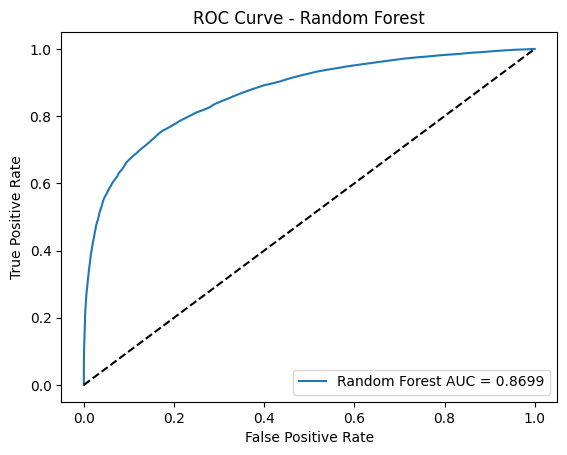

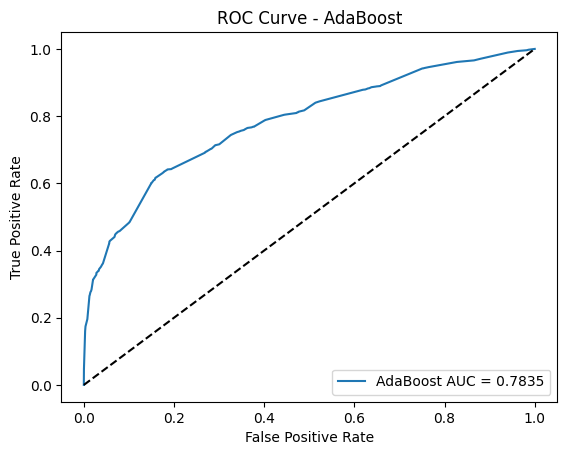

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Predizioni sul test set
y_pred_rf = best_rf.predict(X_test_filtered)
y_pred_ab = best_ab.predict(X_test_filtered)

# 1. Report di classificazione (precision, recall, f1-score)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ab))

# 2. Matrice di confusione
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ab))

# 3. ROC Curve e AUC per Random Forest
y_pred_prob_rf = best_rf.predict_proba(X_test_filtered)[:, 1]  # Probabilità di classe 1
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest AUC = {roc_auc_rf:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# 4. ROC Curve e AUC per AdaBoost
y_pred_prob_ab = best_ab.predict_proba(X_test_filtered)[:, 1]  # Probabilità di classe 1
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_pred_prob_ab)
roc_auc_ab = roc_auc_score(y_test, y_pred_prob_ab)

plt.figure()
plt.plot(fpr_ab, tpr_ab, label=f"AdaBoost AUC = {roc_auc_ab:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Selezioniamo solo le feature con p-value < 0.05
selected_features = t_test_df[t_test_df['P-value'] < 0.05]['Feature']
X_filtered_selected = X_filtered[selected_features]  # Manteniamo solo queste feature
y = train_data_encoded['satisfaction_satisfied']  # Target

print(f"Selected features for the second approach:\n{X_filtered_selected.columns}")

Selected features for the second approach:
Index(['Age', 'Flight Distance', 'Leg room service', 'Checkin service',
       'Departure/Arrival time convenient', 'id'],
      dtype='object')


In [ ]:
# Modelli da valutare
models = {
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# Spot check con cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_filtered_selected, y, cv=5, scoring='accuracy')
    print(f"{model_name} Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


RandomForest Accuracy: 0.7650 ± 0.0021
AdaBoost Accuracy: 0.7379 ± 0.0029
LogisticRegression Accuracy: 0.6233 ± 0.0010


In [ ]:
# Definiamo la griglia di parametri per RandomForest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    cv=5,
    scoring='accuracy'
)

# Esegui la Grid Search su RandomForest
grid_search_rf.fit(X_filtered_selected, y)

print(f"Best RandomForest Params: {grid_search_rf.best_params_}")
print(f"Best RandomForest Accuracy: {grid_search_rf.best_score_:.4f}")

Best RandomForest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best RandomForest Accuracy: 0.7762


In [ ]:
# Definiamo la griglia di parametri per AdaBoost
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search_ab = GridSearchCV(
    AdaBoostClassifier(),
    param_grid_ab,
    cv=5,
    scoring='accuracy'
)

# Esegui la Grid Search su AdaBoost
grid_search_ab.fit(X_filtered_selected, y)

print(f"Best AdaBoost Params: {grid_search_ab.best_params_}")
print(f"Best AdaBoost Accuracy: {grid_search_ab.best_score_:.4f}")

Best AdaBoost Params: {'learning_rate': 0.1, 'n_estimators': 50}
Best AdaBoost Accuracy: 0.7460


In [ ]:
# Valutiamo il modello RandomForest sul test set
X_test_selected = test_data_encoded[selected_features]
y_test = test_data_encoded['satisfaction_satisfied']

best_rf = grid_search_rf.best_estimator_
rf_test_accuracy = best_rf.score(X_test_selected, y_test)
print(f"RandomForest Test Accuracy: {rf_test_accuracy:.4f}")

# Valutiamo il modello AdaBoost sul test set
best_ab = grid_search_ab.best_estimator_
ab_test_accuracy = best_ab.score(X_test_selected, y_test)
print(f"AdaBoost Test Accuracy: {ab_test_accuracy:.4f}")


RandomForest Test Accuracy: 0.7710
AdaBoost Test Accuracy: 0.7419


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.86      0.81     14573
        True       0.79      0.65      0.71     11403

    accuracy                           0.77     25976
   macro avg       0.77      0.76      0.76     25976
weighted avg       0.77      0.77      0.77     25976

AdaBoost Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.84      0.78     14573
        True       0.75      0.62      0.68     11403

    accuracy                           0.74     25976
   macro avg       0.74      0.73      0.73     25976
weighted avg       0.74      0.74      0.74     25976

Random Forest Confusion Matrix:
[[12587  1986]
 [ 3963  7440]]
AdaBoost Confusion Matrix:
[[12216  2357]
 [ 4347  7056]]


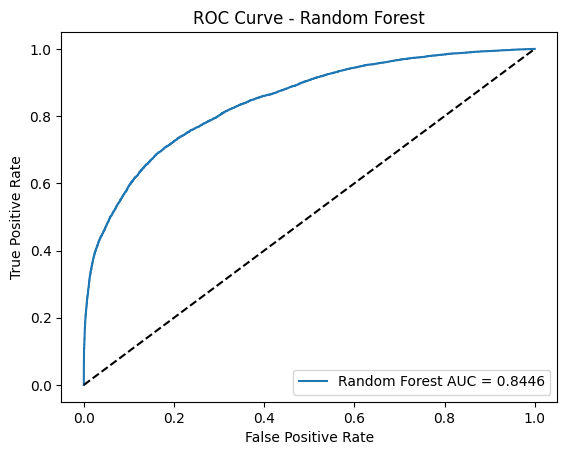

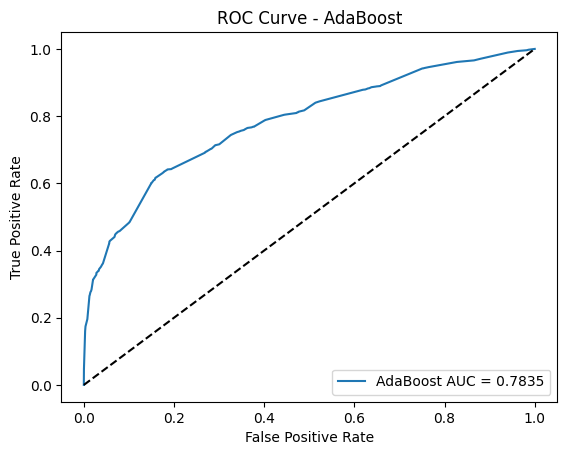

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predizioni sul test set
y_pred_rf = best_rf.predict(X_test_selected)
y_pred_ab = best_ab.predict(X_test_selected)

# 1. Report di classificazione (precision, recall, f1-score)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ab))

# 2. Matrice di confusione
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ab))

# 3. ROC Curve e AUC per Random Forest
y_pred_prob_rf = best_rf.predict_proba(X_test_selected)[:, 1]  # Probabilità di classe 1
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest AUC = {roc_auc_rf:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# 4. ROC Curve e AUC per AdaBoost
y_pred_prob_ab = best_ab.predict_proba(X_test_selected)[:, 1]  # Probabilità di classe 1
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_pred_prob_ab)
roc_auc_ab = roc_auc_score(y_test, y_pred_prob_ab)

plt.figure()
plt.plot(fpr_ab, tpr_ab, label=f"AdaBoost AUC = {roc_auc_ab:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc='lower right')
plt.show()


### Confronto tra la strada 1) e la strada 2)

**Strada 1: Utilizzo di tutte le feature disponibili**
- In questa strada, abbiamo allenato i modelli utilizzando **tutte le feature** disponibili nel dataset, senza alcuna selezione basata su test statistici o altre tecniche di riduzione delle feature.
- Il modello di **Random Forest** ha ottenuto un'accuracy di **0.7983** sul test set, risultando superiore rispetto ad AdaBoost con un'accuracy di **0.7419**.
- Dopo la grid search, il modello Random Forest si è dimostrato robusto e in grado di gestire un set di dati complesso e ricco di feature.
- L'utilizzo di tutte le feature ha permesso di catturare relazioni complesse nei dati, ma potrebbe anche aver introdotto rumore o multicollinearità tra le variabili.

**Strada 2: Selezione delle feature più rilevanti**
- Nella seconda strada, abbiamo selezionato solo le **feature più rilevanti**, basandoci sui risultati del T-test, scegliendo quelle con un p-value molto basso, che indicano una relazione statisticamente significativa con la variabile target.
- I modelli allenati con queste feature selezionate hanno ottenuto risultati simili, ma leggermente più bassi. **Random Forest** ha ottenuto un'accuracy di **0.7710**, mentre AdaBoost ha avuto un'accuracy di **0.7419**.
- Anche se l'accuracy è leggermente inferiore rispetto alla prima strada, la **riduzione delle feature** ha portato a un modello più semplice e più interpretabile, con meno complessità e un addestramento più rapido.

### Confronto complessivo
| Strada               | Modello         | Accuracy (Test Set) | Complessità Modello | Interpretabilità |
|----------------------|-----------------|---------------------|---------------------|------------------|
| **1) Tutte le feature** | Random Forest    | **0.7983**           | Elevata             | Bassa             |
| **1) Tutte le feature** | AdaBoost         | 0.7419               | Media               | Bassa             |
| **2) Feature rilevanti** | Random Forest    | 0.7710               | Minore              | Maggiore          |
| **2) Feature rilevanti** | AdaBoost         | 0.7419               | Minore              | Maggiore          |

### Discussione finale

#### Problema
Il problema era quello di prevedere la **soddisfazione dei clienti** per una compagnia aerea, utilizzando un dataset contenente informazioni su vari aspetti del servizio (es. comfort, check-in, servizi a bordo, ritardi, etc.). Il dataset era composto da una variabile target binaria (soddisfatto o non soddisfatto) e diverse feature, sia numeriche che categoriche.

#### Approccio e soluzioni
Abbiamo esplorato due approcci distinti per risolvere il problema:
1. **Strada 1 (tutte le feature)**: Abbiamo utilizzato tutte le feature disponibili per allenare i modelli, con il risultato che Random Forest ha fornito la migliore accuratezza.
2. **Strada 2 (selezione feature rilevanti)**: Abbiamo ridotto il set di feature selezionando solo quelle più rilevanti dal punto di vista statistico. Anche qui, Random Forest ha dato buoni risultati, ma con una leggera diminuzione delle performance rispetto alla prima strada.

### Conclusioni
- **Miglior modello**: Il miglior modello è risultato essere il **Random Forest** allenato utilizzando **tutte le feature** (strada 1), con un'accuracy del **79.83%** sul test set. Questo suggerisce che, nel caso specifico, l'utilizzo dell'intero set di feature permette al modello di catturare meglio le complessità del problema.
  
- **Vantaggi del Random Forest**:
  - Gestisce bene i dati non lineari.
  - È robusto a outlier e dati rumorosi.
  - Richiede meno pre-processing rispetto ad altri modelli.

- **Scelte di feature**: La selezione delle feature (strada 2) ha portato a un modello leggermente meno performante, ma più semplice e interpretabile. Questo approccio potrebbe essere utile in contesti dove la **velocità di calcolo** e la **riduzione della complessità** sono cruciali, ma nel nostro caso, l'uso di tutte le feature ha offerto performance migliori.

### Riflessione sul problema
Il problema della **soddisfazione dei clienti** è multifattoriale e complesso. I risultati suggeriscono che avere accesso a molteplici aspetti del servizio consente di costruire modelli predittivi migliori, anche se aumenta la complessità del modello. Tuttavia, una riduzione delle feature può ancora dare buoni risultati, specie in contesti dove è necessaria maggiore semplicità o interpretabilità del modello.